In [3]:
#importing Libraries
import re
import numpy as np
import pandas as pd
from collections import Counter
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from bs4 import BeautifulSoup

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = nltk.corpus.stopwords.words("english")
warnings.filterwarnings("ignore")

In [22]:
#Reading data of IMDb dataset
df = pd.read_csv(r"C:\Users\Swapnali\Desktop\Data_ML\IMDB Dataset.csv")
#df = df.iloc[:10000, :]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
#We remove the special characters, stopwords
#BuildVocab class: This is a class designed to build a vocabulary from a given series of sentences (text data). 
#Here are the key methods and functionalities of this class:
def remove_special_characters(text):

    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('[^a-zA-z0-9\s+\,]','',text)
    text = re.sub('\.{2,}','',text)
    return text

def remove_stopwords(text):
    """Function to remove stopwords"""
    text = text.lower()
    words = text.split(" ")
    filtered_words = [i for i in words if i not in stopwords]
    filtered_words = ' '.join(filtered_words)
    return filtered_words

class BuildVocab:
    """Class to build vocabulary for a given series of reviews and vocab size"""
    def __init__(self, sentences: pd.Series, vocab_size:int, unk_token=False):
        self.sentences = sentences
        self.vocab_size = vocab_size
        self.oov_token = unk_token
    
    def __process_sentences(self, sentence:str):
        sentence = re.sub(r'[^a-zA-Z\s+]', '', sentence).strip()
        return sentence
    
    def __sentence2words(self, sentence: str):
        word_list = list()
        for word in sentence.split(" "):
            if len(word) >= 1:
                word_list.append(word)
            else:
                pass
        return list(word_list)
    
    def __get_word_dictionary(self, sentences:list):
        words = list()
        for sentence in sentences:
            word_list = self.__sentence2words(sentence=sentence)
            words.extend(word_list)
        return list(words)
    
    def __get_topn_words(self, word_dictionary:dict):
        sorted_items = sorted(word_dictionary.items(), key=lambda item: item[1], reverse=True)
        top_n_words = [word for word, _ in sorted_items[:self.vocab_size]]
        return top_n_words


    def build(self):
        sentences = self.sentences.apply(self.__process_sentences)
        words = self.__get_word_dictionary(sentences=sentences.values)
        word_count_dict = Counter(words)
        vocab = self.__get_topn_words(word_dictionary=word_count_dict)
        
        if self.oov_token:
            vocab.append("UNK")
        else:
            pass

        index_dict = {x: index for x, index in zip(vocab, range(len(vocab)))}

        return vocab, index_dict


Number of reviews : 50000


<Axes: xlabel='sentiment', ylabel='count'>

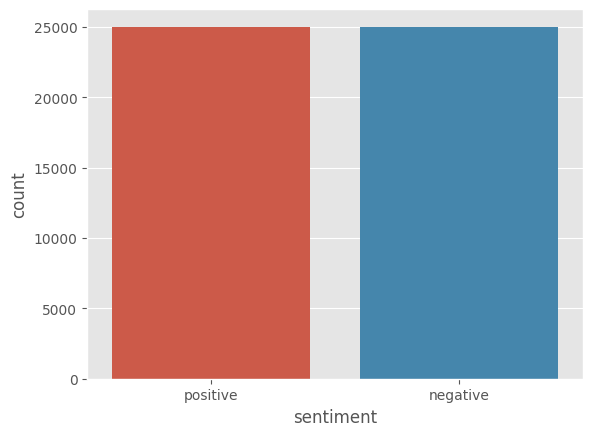

In [24]:
#Counting the number of positive and negative reviews
print(f"Number of reviews : {len(df['review'].values)}")
sns.countplot(data=df, x="sentiment")

In [25]:
#removing stop words and cleaning data
df['review'] = df['review'].apply(remove_special_characters)
df['review'] = df['review'].apply(remove_stopwords)

In [26]:
# Spliting the data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(df['review'].values, df['sentiment'].values, test_size=0.2, random_state=22)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape )

(40000,) (40000,) (10000,) (10000,)


In [27]:
#Training by bag of words model
bow = CountVectorizer(max_features=150)
bow = bow.fit(train_x)

In [28]:
#using N- gram model which N is 3 that is called a Trigram model
N=3
bng = CountVectorizer(ngram_range=(N, N))
bng = bng.fit(train_x)

In [29]:
#using TfIDF feature
tfidf = TfidfVectorizer(max_features=500)
tfidf = tfidf.fit(train_x)

In [30]:
#transforming text data using different vectorization techniques 
bow_train_x, bow_test_x = bow.transform(train_x), bow.transform(test_x)
bng_train_x, bng_test_x = bng.transform(train_x), bng.transform(test_x)
tfidf_train_x, tfidf_test_x = tfidf.transform(train_x), tfidf.transform(test_x)

In [31]:
encoder = LabelBinarizer()
encoder = encoder.fit(train_y)


train_y, test_y = encoder.transform(train_y), encoder.transform(test_y)
print(train_y.shape, test_y.shape)

(40000, 1) (10000, 1)


In [32]:
#logistic regression models are being trained on three different sets of transformed text data, each using a different vectorization technique
lr_bow = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_bow = lr_bow.fit(bow_train_x, train_y)

lr_bng = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_bng = lr_bng.fit(bng_train_x, train_y)

lr_tfidf = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_tfidf = lr_tfidf.fit(tfidf_train_x, train_y)

In [33]:
bow_train_pred = lr_bow.predict(bow_train_x)
bow_test_pred = lr_bow.predict(bow_test_x)

train_acc_bow = accuracy_score(train_y, bow_train_pred)
train_f1_bow = f1_score(train_y, bow_train_pred)

test_acc_bow = accuracy_score(test_y, bow_test_pred)
test_f1_bow = f1_score(test_y, bow_test_pred)


bng_train_pred = lr_bng.predict(bng_train_x)
bng_test_pred = lr_bng.predict(bng_test_x)

train_acc_bng = accuracy_score(train_y, bng_train_pred)
train_f1_bng = f1_score(train_y, bng_train_pred)

test_acc_bng = accuracy_score(test_y, bng_test_pred)
test_f1_bng = f1_score(test_y, bng_test_pred)

tfidf_train_pred = lr_tfidf.predict(tfidf_train_x)
tfidf_test_pred = lr_tfidf.predict(tfidf_test_x)

train_acc_tfidf = accuracy_score(train_y, tfidf_train_pred)
train_f1_tfidf = f1_score(train_y, tfidf_train_pred)

test_acc_tfidf = accuracy_score(test_y, tfidf_test_pred)
test_f1_tfidf = f1_score(test_y, tfidf_test_pred)

In [34]:
#Tabular form of the represented data, as we can clearly see, using the Tf-IDF feature has the highest accuracy, now we use the Tf-IDF method to train 
#train for other algorithms as well
pd.DataFrame({ 
              "test_acc" : [test_acc_bow, test_acc_bng, test_acc_tfidf],
              "test_f1" :  [test_f1_bow, test_f1_bng, test_f1_tfidf]},
              index=['Bag of words', 'Bag of N-grams', 'TFIDF'])

,test_acc,test_f1
Bag of words,0.7667,0.772988
Bag of N-grams,0.7350,0.772415
TFIDF,0.8382,0.839420
